# Demo SingleRun
This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

In [1]:
import datetime, time
import simpy

import shapely.geometry


import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

## Definition of Site

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

from_site = Site(
    env=my_env,
    name="Winlocatie",
    ID="6dbbbdf4-4589-11e9-a501-b469212bff5d",
    geometry=location_from_site,
    capacity=100,
    level=50,
)

to_site = Site(
    env=my_env,
    name="Dumplocatie",
    ID="6dbbbdf5-4589-11e9-82b2-b469212bff5c",
    geometry=location_to_site,
    capacity=50,
    level=0,
)

## Definition of Vessels

In [3]:
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

hopper = TransportProcessingResource(
    env=my_env,
    name="Hopper 01",
    ID="6dbbbdf6-4589-11e9-95a2-b469212bff5b",
    geometry=location_from_site,
    loading_rate=0.00001,
    unloading_rate=0.00001,
    capacity=4,
    compute_v=lambda x: 10,
)

## Definition of process

In [6]:
main_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=hopper,
        destination=from_site,
        duration=1000,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Loading",
        registry=registry,
        processor=hopper,
        origin=from_site,
        destination=hopper,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing filled",
        registry=registry,
        mover=hopper,
        destination=to_site,
        duration=1000,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=hopper,
        origin=hopper,
        destination=to_site,
        amount=4,
        duration=1000,
        start_event=[
            {
                "name": "prepair",
                "type": "activity",
                "state": "done"
            }
        ]
    ),
    model.BasicActivity(
        env=my_env,
        name="Basic activity",
        registry=registry,
        duration=1000,
        additional_logs=[hopper],
    ),
]

main_process = model.SequentialActivity(
    env=my_env,
    name="main_process",
    registry=registry,
    sub_processes=main_processes,
)


helper_processes = [
    model.BasicActivity(
        env=my_env,
        name="prepair",
        registry=registry,
        duration=10000,
        additional_logs=[hopper],
    ),
    model.BasicActivity(
        env=my_env,
        name="clean-up",
        registry=registry,
        duration=1000,
        additional_logs=[hopper],
        start_event=[
            {
                "name": "unloading",
                "type": "activity",
                "state": "done"
            }
        ]
    ),
]
helper_process = model.SequentialActivity(
    env=my_env,
    name="helper_process",
    registry=registry,
    sub_processes=helper_processes,
)

parallel = model.ParallelActivity(
    env=my_env,
    name="parallel",
    registry=registry,
    sub_processes=[helper_process, main_process],
)


while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[parallel],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

In [7]:
model.register_processes([while_activity])
my_env.run()

In [8]:
plot.get_log_dataframe(hopper, [while_activity, *main_processes, main_process])

Activity           Timestamp ActivityState  \
0    37776999-5722-43c6-9d10-9307e414df4c 1970-01-01 00:00:00    WAIT_START   
1    7949d7a4-747e-4f2c-9afa-b32fb79d13dd 1970-01-01 00:00:00    WAIT_START   
2                          Basic activity 1970-01-01 00:00:00    WAIT_START   
3    37776999-5722-43c6-9d10-9307e414df4c 1970-01-01 00:00:00     WAIT_STOP   
4    37776999-5722-43c6-9d10-9307e414df4c 1970-01-01 00:00:00         START   
..                                    ...                 ...           ...   
307  7949d7a4-747e-4f2c-9afa-b32fb79d13dd 1970-01-02 19:03:20         START   
308                        Basic activity 1970-01-02 19:03:20     WAIT_STOP   
309                        Basic activity 1970-01-02 19:03:20         START   
310  7949d7a4-747e-4f2c-9afa-b32fb79d13dd 1970-01-02 19:20:00          STOP   
311                        Basic activity 1970-01-02 19:20:00          STOP   

                           geometry  container level  
0    POINT (4.18055556 52.18664444)              0.0  
1    POINT (4.18055556 52.18664444)              0.0  
2    POINT (4.18055556 52.18664444)              0.0  
3    POINT (4.18055556 52.18664444)              0.0  
4    POINT (4.18055556 52.18664444)              0.0  
..                              ...              ...  
307  POINT (4.25222222 52.11428333)              0.0  
308  POINT (4.25222222 52.11428333)              0.0  
309  POINT (4.25222222 52.11428333)              0.0  
310  POINT (4.25222222 52.11428333)              0.0  
311  POINT (4.25222222 52.11428333)              0.0  

[312 rows x 5 columns]

In [9]:
 plot.vessel_planning([*main_processes, *helper_processes])

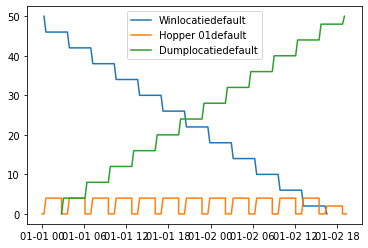

In [10]:
fig = plot.get_step_chart([from_site, hopper, to_site])